In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1: Data Loading and Initial Exploration


In [9]:
df=pd.read_excel('titanic3.xls')
df.head()
'''this inserts the excel dataset into the jupyter notebook. 
I then use .head() for the program to receive the first five lines. 
I usually do this to have everything clearer and more under control.'''

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


exploratory data analysis

In [41]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
'''i want to check the shape of the dataset in order to proceed with the rule of thumb from slide 7'''


Number of rows: 1309
Number of columns: 14


'i want to check the shape of the dataset in order to proceed with the rule of thumb from slide 7'

In [43]:

num_features = df.shape[1]

required_examples = num_features * 10

print(f"Required number of examples (based on rule of thumb): {required_examples}")
print(f"Number of examples in the dataset: {df.shape[0]}")

'''i counted the number of features and wanted to find out the number of examples I would need compared to the minimum 
from the rule of thumb which is at least 10 times the number of features'''


Required number of examples (based on rule of thumb): 140
Number of examples in the dataset: 1309


'i counted the number of features and wanted to find out the number of examples I would need compared to the minimum \nfrom the rule of thumb which is at least 10 times the number of features'

In [14]:
numerical_summary = df.describe()
print(numerical_summary)
'''i wanted to receive numerical statistics for the entirety of the database. This provides
me with the mean, standard deviation, min, max and counts for all of the columns in the 
dataset. 
From these I can already start to tell how much data will be missing from the set, as for example
the count of 'survived' is 1309 but for 'age' we only have 1046, so the values in between the two counts 
are missing from the 'age' column, which will probably pose a challenge soon :(.'''

            pclass     survived          age        sibsp        parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean      2.294882     0.381971    29.881135     0.498854     0.385027   
std       0.837836     0.486055    14.413500     1.041658     0.865560   
min       1.000000     0.000000     0.166700     0.000000     0.000000   
25%       2.000000     0.000000    21.000000     0.000000     0.000000   
50%       3.000000     0.000000    28.000000     0.000000     0.000000   
75%       3.000000     1.000000    39.000000     1.000000     0.000000   
max       3.000000     1.000000    80.000000     8.000000     9.000000   

              fare        body  
count  1308.000000  121.000000  
mean     33.295479  160.809917  
std      51.758668   97.696922  
min       0.000000    1.000000  
25%       7.895800   72.000000  
50%      14.454200  155.000000  
75%      31.275000  256.000000  
max     512.329200  328.000000  


In [35]:
missing_data = df.isnull().sum()
print(missing_data)
'''of course, after looking at the data above I grew curious to see how much data was actually missing. Maybe I did this a bit
prematurely, because the big numbers frightened me quite a bit. From this, we can assume the data is tidy, but quite incomplete
especially in important fields such as age'''

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


'of course, after looking at the data above I grew curious to see how much data was actually missing. Maybe I did this a bit\nprematurely, because the big numbers frightened me quite a bit'

In [45]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
'''i decided to check for duplicates, but none were found, which helps the reliablity of our data'''

Number of duplicate rows: 0


In [ ]:
'''i could also check if the data is expired, but I find that unimportant as this event is not recent and the date
ir irrelevant at least to my knowledge'''

Survival Distribution:
survived
0    809
1    500
Name: count, dtype: int64


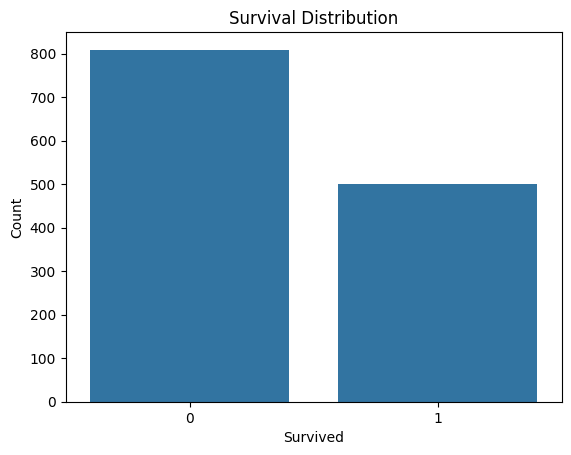

In [46]:

survival_distribution = df['survived'].value_counts()

print("Survival Distribution:")
print(survival_distribution)

sns.countplot(x='survived', data=df)
plt.title("Survival Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.show()

'''the results show that the data is quite unbalanced. I will later think about oversampling or undersampling'''

In [15]:
print(df.dtypes)
'''i then wanted to check what data types I will be working with. The results are 64 bit signed integers, 
floats and objects. '''

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


In [36]:
print(df.columns)
'''before plotting any graph, I needed to know what the columns were named
to make sure I wouldn't get errors from capital letters or misspelling'''

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')


"before plotting any graph, I needed to know what the columns were named\nto make sure I wouldn't get errors from capital letters or misspelling"

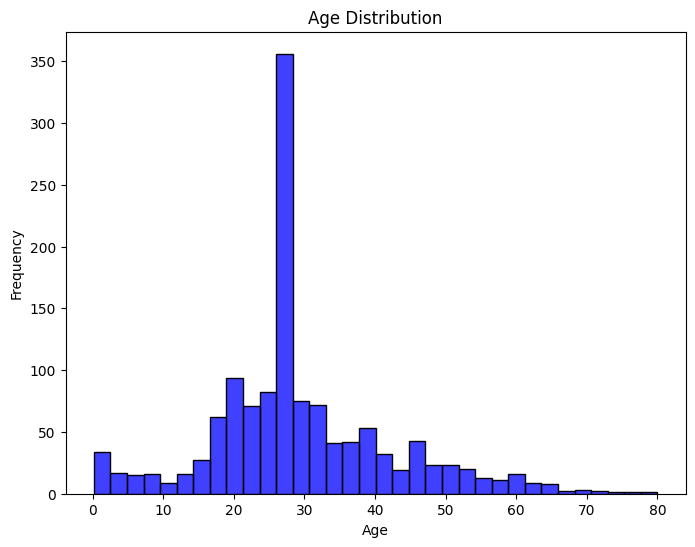

'The age distribution has a peak at 20-30, which relates to the mean found before'

In [55]:
plt.figure(figsize=(8, 6))
sns.histplot(df['age'].dropna(), color='blue')  # Dropping NaN values from 'age'
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
'''I tried to plot everything I could. I have not worked with a dataset like this many times
so I was anxious to make sure I understood it fully, hence the maybe exagerrated
plotting of graphs!(at least now I know how to plot them)'''

'''The age distribution has a peak at 20-30, which relates to the mean found before'''


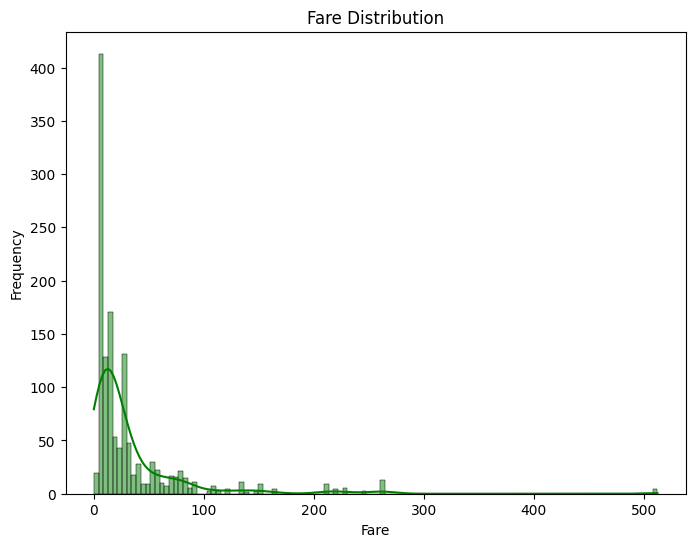

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(df['fare'].dropna(), kde=True, color='green')  # I dropped all NaN values
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()
'''the fare price is depicted below as a frequency graph. I thought this could be relevant as the best rooms/seats 
cost more in general so maybe the higher the fare the higher chance of survival'''


/var/folders/pf/7779b7y95nz06bx7vc4w9dd00000gn/T/ipykernel_38002/792785190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=df, palette='Set1')  # Ensure valid palette


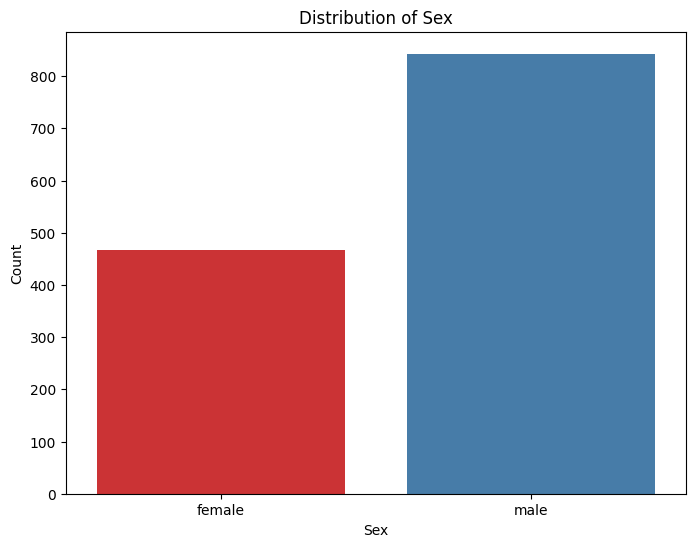

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=df, palette='Set1')  # Ensure valid palette
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()



/var/folders/pf/7779b7y95nz06bx7vc4w9dd00000gn/T/ipykernel_38002/989536166.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pclass', data=df, palette='Set3')  # Ensure valid palette


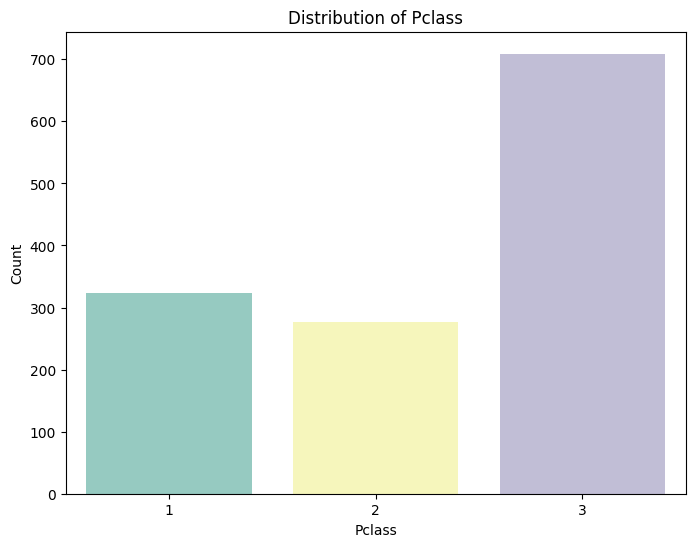

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='pclass', data=df, palette='Set3')  
plt.title('Distribution of Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.show()
'''as with the fare, maybe this has importance as the more expensive the class, the safer the ride. it could
correlate with the chances of survival'''



/var/folders/pf/7779b7y95nz06bx7vc4w9dd00000gn/T/ipykernel_38002/2546811633.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pclass', y='survived', data=df, palette='Blues')  # Correct palette for barplot


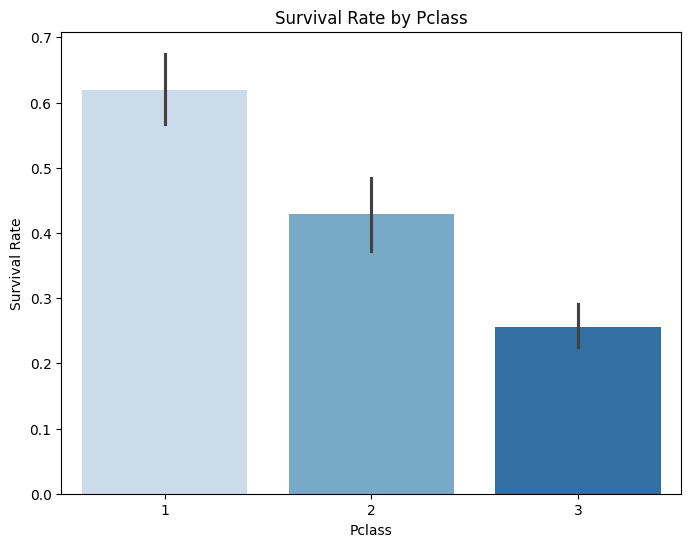

In [31]:
plt.figure(figsize=(8, 6))
sns.barplot(x='pclass', y='survived', data=df, palette='Blues')  # Correct palette for barplot
plt.title('Survival Rate by Pclass')
plt.xlabel('Pclass')
plt.ylabel('Survival Rate')
plt.show()
'''as I grew too curious again, I plotted this graph right away, in hopes of seeing a nice correlation between
the class and the survival rate. I was not disappointed. The survival rate lowers as the class cost lowers. 

The most interesting thing for me is how steady the fall is in survival from the first class onwards. 
They are parted almost perfectly '''

/var/folders/pf/7779b7y95nz06bx7vc4w9dd00000gn/T/ipykernel_38002/3651024159.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='survived', data=df, palette='Blues')


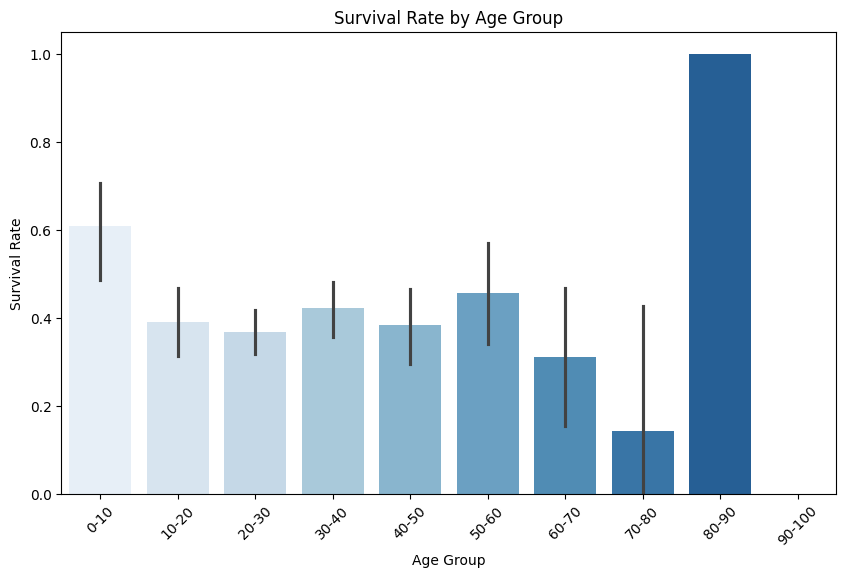

'this is the survival rate by age, which should show a pretty strong correlation however the results are not what was expected at all. \nI am amazed at the survival rate of 90 year olds compared to 20 year olds.  '

In [49]:

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='survived', data=df, palette='Blues')
plt.title('Survival Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.xticks(rotation=45)
plt.show()
'''this is the survival rate by age, which should show a pretty strong correlation however the results are not what was expected at all. 
I am amazed at the survival rate of 90 year olds compared to 20 year olds.This is a clear representation of how incorrect or missing data
affects a model fully and greatly  '''

/var/folders/pf/7779b7y95nz06bx7vc4w9dd00000gn/T/ipykernel_38002/192465558.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sex', y='survived', data=df, palette='Blues')


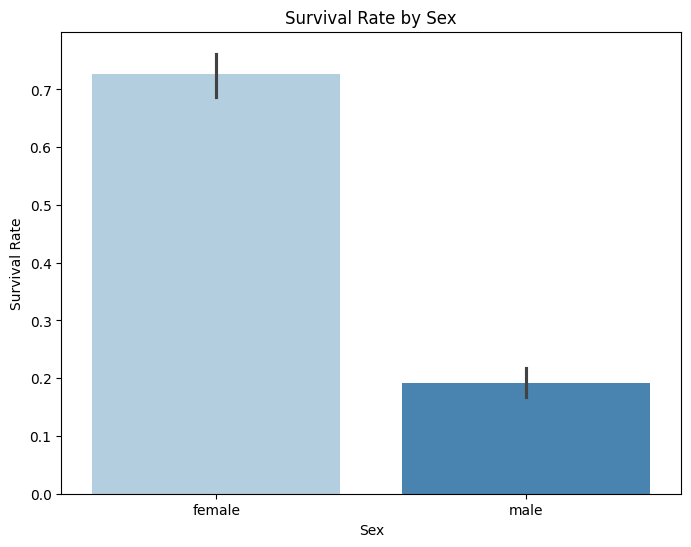

'as a woman myself, I of course sided with one team in particular during this graph plot. Once again, I was not disappointed!\nHowever, on a more serious note, the major difference in survival made me intrigued and motivated to find the reason behind it'

In [54]:
plt.figure(figsize=(8, 6))
sns.barplot(x='sex', y='survived', data=df, palette='Blues')
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.show()

'''as a woman myself, I of course sided with one team in particular during this graph plot. Once again, I was not disappointed!
However, on a more serious note, the major difference in survival made me intrigued and motivated to find the reason behind it'''

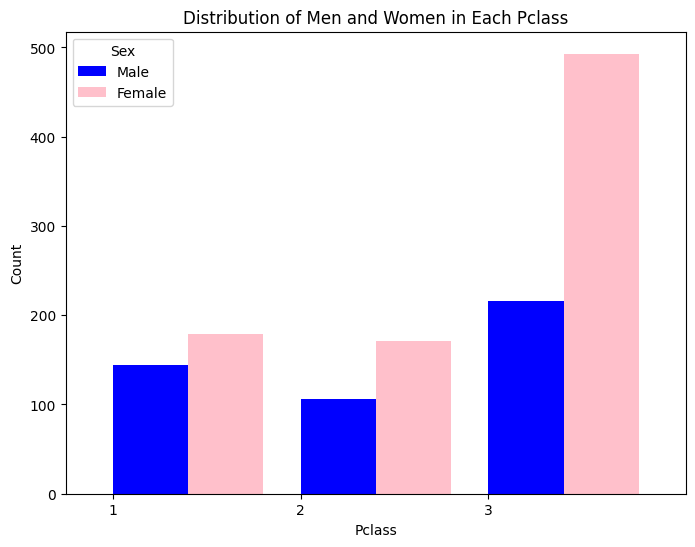

In [40]:
gender_count = df.groupby(['pclass', 'sex']).size().unstack(fill_value=0) #i separated the data into women and men

gender_count.plot(kind='bar', figsize=(8, 6), width=0.8, color=['blue', 'pink'], position=0) 

plt.title('Distribution of Men and Women in Each Pclass')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sex', labels=['Male', 'Female'], loc='upper left')
plt.show()

'''this graph dwells a bit deeper into the survival difference between women and men. My first idea was that the difference in 
survival was this distant because meybe most women were in the first class whereas most men were in the third. However,
it looks as if the men are distributed almost balanced in between classes but most women are in the lowest class. This was a 
very interesting observation for me but made sense because they were meant to let the women and children escape first'''

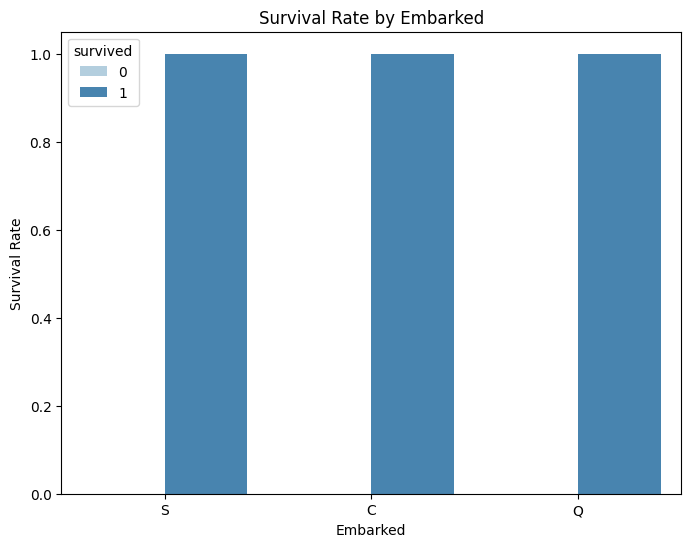

'I thought survival rate could have something to do with where the people embarked from, although I think it is kind of a big\nstretch. I think the difference is due to chance'

In [53]:
plt.figure(figsize=(8, 6))
sns.barplot(x='embarked', y='survived', data=df, palette='Blues', hue='survived')
plt.title('Survival Rate by Embarked')
plt.xlabel('Embarked')
plt.ylabel('Survival Rate')
plt.show()

'''I thought survival rate could have something to do with where the people embarked from, although I think it is kind of a big
stretch. I think the difference is due to chance'''

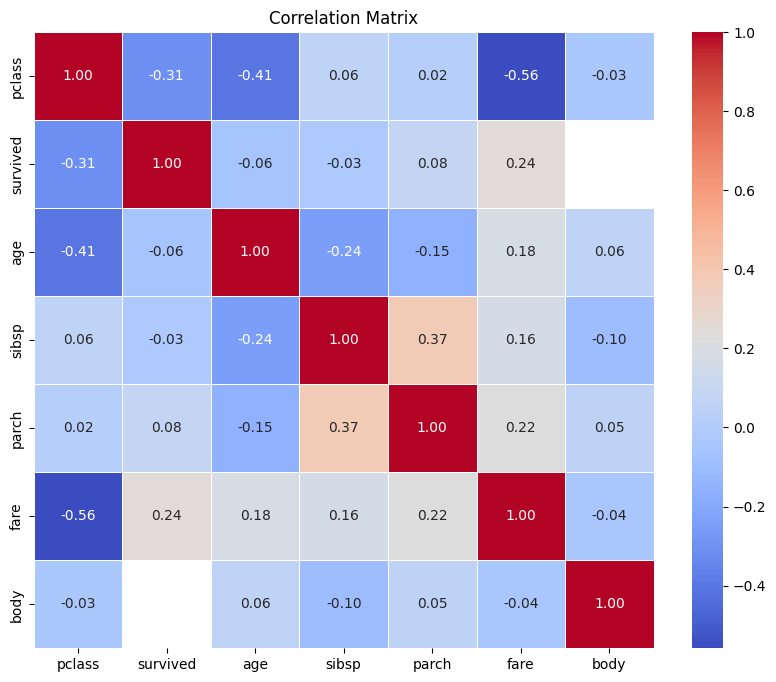

In [34]:
numeric_cols = df.select_dtypes(include=['number']).columns #i only selected the numerical columns

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

'''I plotted a correlation matrix. I asked ChatGPT how else I could see correlations between different columns and it
suggested a correlation matrix, so here it is

From the matrix we can see that the column that correlates with survival the most is the class the individual travelled in'''

## Task 2: Managing Missing Values

In [47]:
missing_data = df.isnull().sum()
print(missing_data)
'''as already done above, I will find the sounts of missing data from the dataset. There is quite a lot of missing data, 
especially for age, which is quite an important predictor for survival'''

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


'as already done above, I will find the sounts of missing data from the dataset'

In [52]:
df['age'] = df['age'].fillna(df['age'].median())
df['fare'] = df['fare'].fillna(df['fare'].median())

'''because age is important when it comes to survival predictors, I can not just delete the incomplete rows. However, from the summary of 
statistics done at the beginning, including quartiles, mean, standard deviations and median, we can see that the 'age' category has its 
mean and median pretty close to one another, and I believe we can assume that it is normally distributed almost. Because of this I think
it is fair to replace missing values with the median of the column.

However, for the 'fare' column, the mean is very small compared to the median. because of this, I can not use the average as a filler for
missing data and will use the median, as it is more reliable for skewed data'''

"because age is important when it comes to survival predictors, I can not just delete the incomplete rows. However, from the summary of \nstatistics done at the beginning, including quartiles, mean, standard deviations and median, we can see that the 'age' category has its \nmean and median pretty close to one another, and I believe we can assume that it is normally distributed almost. Because of this I think\nit is fair to replace missing values with the median of the column.\n\nHowever, for the 'fare' column, the mean is very small compared to the median. because of this, I can not use the average as a filler for\nmissing data and will use the median, as it is more reliable for skewed data"

## Task 3: Encoding Categorical Variables

## Task 4: Feature Scaling

## Task 5: Data Splitting

## Task 6: Addressing Class Imbalance

## Task 7: Feature Selection

## Task 8: Training a Logistic Regression Model